<h3>准备</h3>

<h4>导入包</h4>

In [1]:
import os
import json
import requests
from time import localtime, strftime
from typing import Optional, Union
from PIL.Image import Image, open, fromarray
from PIL.ImageFilter import FIND_EDGES
import numpy as np
import tensorflow as tf
from tensorflow import Tensor
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, LeakyReLU, Flatten, Lambda
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import History, Callback, TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session
from sklearn.metrics import classification_report

2023-11-13 10:34:35.311942: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 10:34:35.311974: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 10:34:35.311991: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 10:34:35.316681: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 10:34:35.820034: W tensorflow/compiler/

<h4>设置tensorflow</h4>

In [2]:
tf.__version__

'2.14.0'

In [3]:
tf.compat.v1.enable_eager_execution()
for gpu in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

2023-11-13 10:34:37.709767: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 10:34:37.864664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 10:34:37.865222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

<h3>准备数据</h3>

In [4]:
train_dir = os.path.join("../data/pic/", "train")
test_dir = os.path.join("../data/pic/", "test")

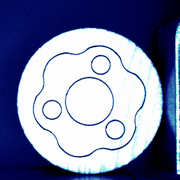

In [5]:
# 查看一张图片
image = open("/home/wxy/Industrial-Algorithm-Competition/data/pic/train/0/616bb0a2ac4eb86ec92bf933.png")
image

<h4>边缘检测</h4>

In [6]:
def find_edges(img: Union[np.ndarray, Image]) -> np.ndarray:
    """
    图片边缘检测\n
    :param img: 一张图片
    :return: 边缘检测后的图片
    """
    if isinstance(img, np.ndarray):
        image: Image = fromarray(img.astype(np.uint8))
    else:
        image: Image = img
    return np.array(image.filter(FIND_EDGES)).astype("float")

<h4>数据预处理</h4>

In [7]:
train_gen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360,
    width_shift_range=0.03,
    height_shift_range=0.03,
    fill_mode='nearest',
    validation_split=0.2
)
val_gen = ImageDataGenerator(
    validation_split=0.2
)

In [8]:
train_ds = train_gen.flow_from_directory(
    train_dir,
    target_size=(160, 160),
    color_mode='rgb',
    class_mode='sparse',
    batch_size=32,
    shuffle=True,
    seed=123,
    subset="training"
)
val_ds = train_gen.flow_from_directory(
    train_dir,
    target_size=(160, 160),
    color_mode='rgb',
    class_mode='sparse',
    batch_size=32,
    shuffle=True,
    seed=123,
    subset="validation"
)

Found 89 images belonging to 2 classes.
Found 21 images belonging to 2 classes.


<h3>搭建模型并训练</h3>

<h4>搭建模型</h4>

In [9]:
clear_session()
model = Sequential([
    Resizing(320, 320, name="resize", input_shape=(320, 320, 3)),
    Rescaling(1.0 / 255, name="rescale"),
    Conv2D(filters=64, kernel_size=(3, 3), data_format="channels_last", activation="relu", name="conv2d1"),
    MaxPool2D(pool_size=(2, 2), name="maxpool2d_1"),
    Conv2D(filters=128, kernel_size=(3, 3), data_format="channels_last", activation="relu", name="conv2d2"),
    MaxPool2D(pool_size=(2, 2), name="maxpool2d_2"),
    Conv2D(filters=128, kernel_size=(3, 3), data_format="channels_last", activation="relu", name="conv2d3"),
    MaxPool2D(pool_size=(2, 2), name="maxpool2d_3"),
    Conv2D(filters=64, kernel_size=(3, 3), data_format="channels_last", activation="relu", name="conv2d4"),
    MaxPool2D(pool_size=(2, 2), name="maxpool2d_4"),
    Conv2D(filters=32, kernel_size=(3, 3), data_format="channels_last", activation="relu", name="conv2d5"),
    MaxPool2D(pool_size=(2, 2), name="maxpool2d_5"),
    Conv2D(filters=16, kernel_size=(3, 3), data_format="channels_last", activation="relu", name="conv2d6"),
    MaxPool2D(pool_size=(2, 2), name="maxpool2d_6"),
    Flatten(data_format="channels_last", name="flatten_7"),
    Dense(units=16, activation="relu", name="dense_7"),
    Dense(units=2, activation="sigmoid", name="dense_8")
], name="pic_clf")
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=1e-4),
    metrics=["accuracy"]
)
model.summary()

Model: "pic_clf"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resize (Resizing)           (None, 320, 320, 3)       0         
                                                                 
 rescale (Rescaling)         (None, 320, 320, 3)       0         
                                                                 
 conv2d1 (Conv2D)            (None, 318, 318, 64)      1792      
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 159, 159, 64)      0         
                                                                 
 conv2d2 (Conv2D)            (None, 157, 157, 128)     73856     
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 78, 78, 128)       0         
                                                                 
 conv2d3 (Conv2D)            (None, 76, 76, 128)       1475

2023-11-13 10:34:43.309302: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 10:34:43.309519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 10:34:43.309638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [ ]:
# import tensorflow_hub as hub

# model = tf.keras.Sequential([
#     hub.KerasLayer("/home/wxy/Industrial-Algorithm-Competition/models/imagenet_efficientnet_v2_imagenet1k_s_classification_2", trainable=True)
# ])
# # module_spec = hub.load_module_spec("/home/wxy/Industrial-Algorithm-Competition/models/imagenet_efficientnet_v2_imagenet1k_s_classification_2")
# # height, width = hub.get_expected_image_size(module_spec)
# # height, width
# model.compile(    
#     loss=SparseCategoricalCrossentropy(from_logits=True),
#     optimizer=Adam(learning_rate=1e-4),
#     metrics=["accuracy"]
# )
# model.build([None, 384, 384, 3])

<h4>模型训练</h4>

In [10]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=120,
    batch_size=16,
    verbose=1,
    workers=-1,
    use_multiprocessing=True,
    callbacks=[
        TensorBoard(log_dir="../logs/" + strftime("%Y%m%d-%H%M%S", localtime()))
    ]
)

Epoch 1/120


2023-11-13 10:34:47.387904: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
/usr/local/miniconda3/envs/tensorflowcv/lib/python3.9/site-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-11-13 10:34:48.753394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8801
2023-11-13 10:34:48.825215: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-13 10:34:49.161077: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f93ec0194d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-13 10:34:49.161096: I tensorflow/compiler/xla/service/service.cc:176]   

3/3 [==============================] - 6s 1s/step - loss: 0.6649 - accuracy: 0.7191 - val_loss: 0.6472 - val_accuracy: 0.7143
Epoch 2/120
3/3 [==============================] - 0s 174ms/step - loss: 0.6334 - accuracy: 0.7191 - val_loss: 0.6155 - val_accuracy: 0.7143
Epoch 3/120
3/3 [==============================] - 0s 155ms/step - loss: 0.6090 - accuracy: 0.7191 - val_loss: 0.5968 - val_accuracy: 0.7143
Epoch 4/120
3/3 [==============================] - 0s 176ms/step - loss: 0.5916 - accuracy: 0.7191 - val_loss: 0.5992 - val_accuracy: 0.7143
Epoch 5/120
3/3 [==============================] - 0s 173ms/step - loss: 0.5941 - accuracy: 0.7191 - val_loss: 0.6009 - val_accuracy: 0.7143
Epoch 6/120
3/3 [==============================] - 0s 171ms/step - loss: 0.5935 - accuracy: 0.7191 - val_loss: 0.5970 - val_accuracy: 0.7143
Epoch 7/120
3/3 [==============================] - 0s 172ms/step - loss: 0.5935 - accuracy: 0.7191 - val_loss: 0.5933 - val_accuracy: 0.7143
Epoch 8/120
3/3 [===========

In [ ]:
!tensorboard --logdir ../logs --bind_all

In [ ]:
# save_model(model, "home/centos/pic_clf/4")     
save_model(model, "../models/pic_clf/7")

In [ ]:
model = tf.keras.models.load_model('../models/pic_clf/7')

<h3>部署模型并预测</h3>

<h4>部署模型</h4>

<h5>安装docker</h5>

In [ ]:
# !sudo yum install -y epel-release
# !sudo yum install https://get.docker.com/rpm/1.7.1/centos-6/RPMS/x86_64/docker-engine-1.7.1-1.el6.x86_64.rpm
# !docker version
# !sudo service docker start

<h5>拉取镜像</h5>

In [ ]:
tf.__version__

In [ ]:
# !docker pull tensorflow/serving:2.14.0-gpu

<h5>部署服务</h5> 

TODO: 
检查部署的是哪个版本

In [ ]:

!docker run -t \
    -p 9990:9990 \
    -v "/home/wxy/Industrial-Algorithm-Competition/models/pic_clf/7:/models/pic_clf/7" \
    -e MODEL_NAME=pic_clf \
    tensorflow/serving:2.14.0-gpu

<h4>测试数据</h4>

<h5>读取测试数据</h5>

In [ ]:
x_test, y_test = list(image_dataset_from_directory(test_dir, image_size=(320, 320)))[1]

In [ ]:
x_test.shape, y_test.shape, len([i for i in y_test if i == 0]), len([i for i in y_test if i == 1])

In [ ]:
# from PIL import Image
# x_test_image = Image.fromarray(x_test[1].astype('uint8')).convert('RGB')
# x_test_image

In [ ]:
x_test = x_test.numpy()
y_test = y_test.numpy()

<h5>预测数据</h5>

In [ ]:
data = json.dumps({"instances": x_test.tolist()})
headers = {"content-type": "application/json"}
response = requests.post(
    url="http://172.17.0.4:8501/v1/models/pic_clf:predict",
    data=data,
    headers=headers
)
if response.status_code != 200:
    raise ValueError(response.text)


In [ ]:
response.text

In [ ]:
y_pred_prob = np.array(json.loads(response.text)["predictions"])

In [ ]:
y_pred = np.where(y_pred_prob[:, 0] > y_pred_prob[:, 1], 0, 1).ravel()

In [ ]:
print(classification_report(y_test, y_pred))
print("test data label 0 num: ", str(len([i for i in y_test if i == 0])), '\ntest data label 1 num: ', str(len([i for i in y_test if i == 1])))